<a href="https://colab.research.google.com/github/hanmisil/Fintech_AI_Hackathon/blob/master/AI-Study/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Image captioning with visual attention</h1>


In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json

# glob 모듈은 파일들의 리스트를 뽑을 때 사용하는데, 파일의 경로명을 이용해서 파일을 저장하기 위해 사용
from glob import glob
# 파이썬에서 이미지 처리를 하기위해 사용
from PIL import Image
# pickle 모듈은 파이썬에서 만들어지는 것은 뭐든지 다 파일에 적을 수 있기 위해 사용
import pickle

Download and prepare the MS-COCO dataset

- os.path.exists : path가 기존 경로 열린 파일 기술자를 참조하면 True를 반환한다.
- os.path.abspath : 특정 경로에 대해 절대 경로를 반환한다.
- os.path.dirname : 경로명 path의 디렉토리 이름을 반환한다.
- tf.keras.utils.get_file : 인터넷의 파일을 로컬 컴퓨터의 홈 디렉토리 아래 .keras/datasets 디렉토리로 다운로드한다.

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 326s 0us/step


<h1>Optional : limit the size of the training set</h1>

- 훈련 세트의 크기를 제한<br>
- 학습 속도를 높이기 위해 30,000개의 caption(설명)과 해당 이미지를 사용하여 모델을 학습시킨다. 더 많은 데이터를 사용하도록 선택하면 캡션 품질이 향상된다.

In [ ]:
# Read the json file
# json : XML, YAML과 함께 효율적으로 데이터를 저장하고 교환하는데 사용하는 텍스트 데이터 포맷 중 하나
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [ ]:
annotations['annotations'][:10]

[{'caption': 'A very clean and well decorated empty bathroom',
  'id': 48,
  'image_id': 318556},
 {'caption': 'A panoramic view of a kitchen and all of its appliances.',
  'id': 67,
  'image_id': 116100},
 {'caption': 'A blue and white bathroom with butterfly themed wall tiles.',
  'id': 126,
  'image_id': 318556},
 {'caption': 'A panoramic photo of a kitchen and dining room',
  'id': 148,
  'image_id': 116100},
 {'caption': 'A graffiti-ed stop sign across the street from a red car ',
  'id': 173,
  'image_id': 379340},
 {'caption': 'A vandalized stop sign and a red beetle on the road',
  'id': 188,
  'image_id': 379340},
 {'caption': 'A bathroom with a border of butterflies and blue paint on the walls above it.',
  'id': 219,
  'image_id': 318556},
 {'caption': 'An angled view of a beautifully decorated bathroom.',
  'id': 255,
  'image_id': 318556},
 {'caption': 'The two people are walking down the beach.',
  'id': 272,
  'image_id': 134754},
 {'caption': 'A sink and a toilet inside

In [ ]:
caption

'<start> A dinner plate has a lemon wedge garnishment. <end>'

In [ ]:
PATH

'/content/train2014/'

In [ ]:
all_captions[:10]

['<start> A very clean and well decorated empty bathroom <end>',
 '<start> A panoramic view of a kitchen and all of its appliances. <end>',
 '<start> A blue and white bathroom with butterfly themed wall tiles. <end>',
 '<start> A panoramic photo of a kitchen and dining room <end>',
 '<start> A graffiti-ed stop sign across the street from a red car  <end>',
 '<start> A vandalized stop sign and a red beetle on the road <end>',
 '<start> A bathroom with a border of butterflies and blue paint on the walls above it. <end>',
 '<start> An angled view of a beautifully decorated bathroom. <end>',
 '<start> The two people are walking down the beach. <end>',
 '<start> A sink and a toilet inside a small bathroom. <end>']

In [ ]:
all_img_name_vector[:10]

['/content/train2014/COCO_train2014_000000318556.jpg',
 '/content/train2014/COCO_train2014_000000116100.jpg',
 '/content/train2014/COCO_train2014_000000318556.jpg',
 '/content/train2014/COCO_train2014_000000116100.jpg',
 '/content/train2014/COCO_train2014_000000379340.jpg',
 '/content/train2014/COCO_train2014_000000379340.jpg',
 '/content/train2014/COCO_train2014_000000318556.jpg',
 '/content/train2014/COCO_train2014_000000318556.jpg',
 '/content/train2014/COCO_train2014_000000134754.jpg',
 '/content/train2014/COCO_train2014_000000538480.jpg']

In [ ]:
train_captions[:10]

['<start> A skateboarder performing a trick on a skateboard ramp. <end>',
 '<start> a person soaring through the air on skis <end>',
 '<start> a wood door with some boards laid against it <end>',
 '<start> A Do Not Enter sign is posted along a road leading to a stadium. <end>',
 '<start> Small child in a high chair eating off of a green plate.  <end>',
 '<start> groups of people standing around the toilet area <end>',
 '<start> a hand is holding a black and silver cellphone <end>',
 '<start> People working on laptop computers in a student dining room <end>',
 '<start> two birds near one another in a field  <end>',
 '<start> A man talking on a cell phone in a park. <end>']

In [ ]:
len(train_captions), len(all_captions)

(30000, 414113)

In [ ]:
len(img_name_vector), len(all_img_name_vector)

(30000, 414113)

<h1>InceptionV3를 이용하여 이미지 전처리 </h1>
- 사전에 훈련된 inceptionV3를 이용하여 각 이미지를 분류한다. <br>
- 마지막 컨볼루션 레이어에서 features를 추출한다. <br>
- 이미지 처리 분야에서 특정 Feature(특징)들을 추출하기 위해 Convolution 사용<br>
- InceptionV3를 훈련시키는 데 사용되는 이미지의 형식과 일치하도록 이미지 변환한다. <br>
- 이미지를 resize -> 299px X 299px로 크기 조정
- preprocess_input 메소드를 사용하여 이미지를 전처리하여 <br>
이미지를 정규화하여 -1에서 1사이의 픽셀을 포함하도록 한다. <br>

<h1>InceptionV3</h1>
imageNet 데이터베이스의 1백만 개가 넘는 영상에 대해 훈련된 컨볼루션 신경망을 말한다. 이 네트워크에는 48개의 계층이 있으며, 영상을 키보드, 마우스, 연필, 각종 동물 등 1,000가지 사물 범주로 분류할 수 있다. 그 결과 이 네트워크는 다양한 영상을 대표하는 다양한 특징을 학습한다. <br>
- 네트워크의 영상 입력 크기 : 299 x 299 <br>
- classify로 영상을 분류할 수 있다. <br>
- tf.decode_jpeg : JPEG로 인코딩 된 이미지를 uint8 텐서로 디코딩한다.

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    # decode_jpeg : JPEG로 인코딩 된 이미지를 텐서로 디코딩 한다.
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    # preprocess_input 메소드를 사용하여 이미지를 사전처리하고 정규화하여 -1에서 1사이의 픽셀을 포함하도록 한다.
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

<h1>inceptionV3 초기화 및 사진 훈련된 imagenet 가중치 로드 </h1>

- inceptionV3 아키텍쳐안에 있는 마지막 컨볼루션 층을 만든다.<br>
- 이러한 층의 output의 모양은 8x8x2048의 형태이다.<br>
- attention을 사용하기 위해 마지막 컨볼루션 층을 사용한다.<br>
- 병목 현상이 발생할 수 있으므로 훈련 중에는 초기화를 하지 않는것이 좋다.<br>

> - 각 이미지를 통해 네트워크에 전달하고 결과벡터를 dictionary(image_name->feature_Vector)에 저장한다. <br>
> - 모든 이미지가 네트워크를 통과한 후, 사전에 저장하고 디스크에 저장한다. <br>



<h1>tf.keras.applications.InceptionV3</h1>
- include_top : 맨 위(상단)에 완전히 연결된 계층을 네트워크의 마지막 계층으로 포함할지 여부이다. 기본값으로는 True <br>
- weights : None(랜덤 초기화), imagenet(Imagenet에서 사전 훈련된 가중치)또는 로드할 가중치 파일의 경로이다. 기본값으로는 imagenet <br>


In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
a = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
b=a.input
b

<tf.Tensor 'input_2:0' shape=(None, 299, 299, 3) dtype=float32>

In [ ]:
c = a.layers[-1].output
c

<tf.Tensor 'predictions/Identity:0' shape=(None, 1000) dtype=float32>

In [ ]:
a.output

<tf.Tensor 'predictions/Identity:0' shape=(None, 1000) dtype=float32>

In [ ]:
new_input, hidden_layer

(<tf.Tensor 'input_1:0' shape=(None, None, None, 3) dtype=float32>,
 <tf.Tensor 'mixed10/Identity:0' shape=(None, None, None, 2048) dtype=float32>)

In [ ]:
image_model.output

<tf.Tensor 'mixed10/Identity:0' shape=(None, None, None, 2048) dtype=float32>

In [ ]:
image_model.layers[-1]

In [ ]:
len(image_features_extract_model.layers)

311

<h1> Caching the feature extracted from inceptionV3</h1>
각각의 데이터를 사전 처리(pre-process)하고 디스크에 output을 저장한다. <br>
RAM에 output을 저장하는 것은 빠르지만 많은 메모리를 사용하므로 이미지 당 8x8x2048 float이 필요하다. <br>
작성하는 동안 코랩의 메모리 제한을 초과한다.

In [ ]:
from tqdm import tqdm

tf.data.Dataset.from_tensor_slices <br>
- 만약 모든 데이터가 메모리에 존재한다면, 이들로 부터 Dataset을 만드는 가장 간단한 방법은 Dataset.from_tensor_slices()을 사용하여 tf.tensor()로 변환하는 것이다. <br>
- 또한, tf.data.Dataset.from_tensor()을 이용하여 만들 수 있다. <br>
- 결과 값을 확인해 보면 전체데이터가 저장 됨 <br><br>

Datasets transformation <br>
- tf.data.Dataset.map()을 이용하여 전체 데이터셋에 변형 가능


<h1>성능 최적화</h1>
<h2> 데이터 변환 병렬화 </h2>
데이터를 준비할 때, 입력 요소들은 전처리가 필요하다. 이것 때문에 tf.data API가 tf.data.Dataset.map 변환을 제공하고, 그것은 사용자 정의 함수를 입력 데이터셋의 각 요소에 적용한다. 입력 요소가 서로 독립적이기 때문에 전처리는 여러 개의 CPU(GPU) 코어에서 병렬로 실행될 수 있다. <br><br>
이를 가능하게 하기 위해 prefetch 및 interleave 변환과 유사하게 map변환은 병렬 처리 레벨을 지정하기 위해 num_parallel_calls 인수를 제공한다. <br><br>

가장 좋은 num_parallel_calls 값은 하드웨어, 훈련 데이터(사이즈와 모양), 맵 함수의 비용, 그리고 CPU에서 동시에 어떤 처리가 수행되는지에 따라 다르다. 단순한 방법으로 가용한 코어의 숫자로 설정할 수 있다. 반면에 num_parallel_calls를 가용한 CPU 코어 숫자보다 훨씬 더 많이 설정한다면 비효율적인 스케줄링으로 느려진다. <br><br>
tf.data.experimental.AUTOTUNE <br>
- prefetch와 interleave 변환과 비슷하게 map변환은 tf.data 런타임에 가용되는 병렬화 수준을 결정하는 tf.data.experimental.AUTOTUNE를 제공한다.
- 병렬 매핑을 위해 사용한다.
-

<h1>Bottlenecks</h1>
가장 먼저 사진들에 대해 분석하고, 계산해서 저장하는 값들은 bottleneck값이 된다. <br>
'Bottleneck'이란 실제 분류가 진행되는 마지막 층(Final output layer) 이전의 layer를 지칭하는 비공식적인 용어다. <br>
매우 작은 값들을 선택해 잘 분류하기 위한 충분한 정보들을 가지기 때문에, 이 layer들은 이미지의 의미있는 압축된 요약본이라 할 수 있다. <br>
마지막 레이어를 재학습시키는 것이 잘 작동하는 이유는 1000개의 클래스가 있는 Imagenet을 학습시킨 것이 다른 새로운 종류의 개체를 구별하는데 유용하기 때문이다.

In [ ]:
# Get unique images
# 30000개의 데이터 중 중복을 제거한 뒤 정렬
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

1622it [06:51,  3.94it/s]


In [ ]:
len(encode_train)

25950

In [ ]:
a = tf.data.Dataset.from_tensor_slices(encode_train)
b = tf.data.Dataset.from_tensors(encode_train)
a, b

(<TensorSliceDataset shapes: (), types: tf.string>,
 <TensorDataset shapes: (25950,), types: tf.string>)

In [ ]:
image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

In [ ]:
image_features_extract_model(img).shape

TensorShape([14, 8, 8, 2048])

In [ ]:
batch_features.shape

TensorShape([14, 64, 2048])

In [ ]:
batch_features[:2]

<tf.Tensor: shape=(2, 64, 2048), dtype=float32, numpy=
array([[[0.        , 0.01891623, 0.43744224, ..., 0.        ,
         0.00293287, 0.05505414],
        [0.        , 0.45677003, 0.16872278, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.05066632, 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.32989457, 0.        , ..., 0.        ,
         0.        , 0.17409787],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.49067512],
        [0.        , 2.3365517 , 0.        , ..., 0.6360595 ,
         0.        , 1.4810282 ],
        ...,
        [0.3706854 , 1.0731797 , 0.        , ..., 0. 

<h1>Preprocess and tokenize the caption</h1>
1. 캡션을 토큰화 한다(공백을 분할). 이를 통해 데이터에 있는 모든 독특한 단어에 대한 어휘를 알 수 있다. <br>
2. 단어의 크기를 상위 5000단어로 제한하여 메모리를 절약한다. 다른 모든 단어는 토큰("UNK", 알수없음)으로 대체된다.<br>
3. 그런 다음 단어:인덱스, 인덱스:단어 를 매핑한다. <br>
4. 마지막으로 모든 시퀀스를 가장 긴 스퀀스와 동일한 길이로 채운다. <br><br>

토큰화(Tokenization)<br>
토큰의 기준을 단어(word)로 하는 경우, 단어 토큰화라고 한다. 다만, 여기서 단어는 단위 외에도 단어구, 의미를 갖는 문자열로 간주된다.

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

tf.keras.preprocessing.text.Tokenizer <br>
- 이 클래스를 사용하면 각 텍스트를 정수 시퀀스 또는 단어 수를 기준으로 각 토큰의 계수가 이진일 수 있는 벡터로 변환하여 텍스트 코퍼스를 벡터화할 수 있다. <br>
- num_words : 단어 빈도에 따라 유지할 최대 단어 수<br>
- oov_token : word_index에 추가되고 text_to_sequence 호출 중에 어휘를 벗어난 단어를 대체하는 데 사용<br>
- filters(구두점) : 각 요소가 텍스트에서 필터링되는 문자 인 문자열로 기본값은 문자를 제외한 모든 구두점과 탭 및 줄바꿈
<br>


fit_on_texts <br>
- 텍스트 목록을 기반으로 내부 어휘를 업데이트 한다. 이 방법으로 단어의 빈도에 따라 어휘 색인을 만든다. 모든 단어는 고유 한 정수를 갖게 된다. 0은 패딩 용으로 사용되고 나머지 단어는 정수가 낮을수록 단어가 더 자주 나타난다. <br>

texts_to_sequences<br>
- 텍스트의 각 텍스트를 정수 시퀀스로 변환한다. <br>
- 적합 어휘 색인을 사용하여 완전히 새로운 word 시퀀스 세트를 나타낸다.
- 훈련/평가/테스트/예측 시간에 정확히 동일한 word_index 사전을 사용하여 실제 텍스트를 시퀀스로 변환하여 네트워크에 공급한다. <br><br>

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
train_seqs[:10]

[[3, 2, 351, 687, 2, 280, 5, 2, 84, 339, 4],
 [3, 2, 31, 2356, 112, 7, 137, 5, 159, 4],
 [3, 2, 318, 284, 9, 28, 525, 1083, 305, 30, 4],
 [3, 2, 1118, 845, 1539, 57, 11, 1203, 219, 2, 91, 1008, 13, 2, 1290, 4],
 [3, 37, 152, 8, 2, 376, 155, 127, 214, 6, 2, 65, 39, 4],
 [3, 1823, 6, 17, 19, 109, 7, 90, 108, 4],
 [3, 2, 199, 11, 27, 2, 40, 10, 432, 556, 4],
 [3, 17, 479, 5, 111, 613, 8, 2, 2984, 471, 44, 4],
 [3, 16, 335, 42, 100, 202, 8, 2, 36, 4],
 [3, 2, 12, 290, 5, 2, 173, 115, 8, 2, 143, 4]]

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
tokenizer.word_index

{'<unk>': 1,
 'a': 2,
 '<start>': 3,
 '<end>': 4,
 'on': 5,
 'of': 6,
 'the': 7,
 'in': 8,
 'with': 9,
 'and': 10,
 'is': 11,
 'man': 12,
 'to': 13,
 'sitting': 14,
 'an': 15,
 'two': 16,
 'people': 17,
 'at': 18,
 'standing': 19,
 'are': 20,
 'white': 21,
 'next': 22,
 'woman': 23,
 'street': 24,
 'table': 25,
 'that': 26,
 'holding': 27,
 'some': 28,
 'large': 29,
 'it': 30,
 'person': 31,
 'down': 32,
 'top': 33,
 'up': 34,
 'group': 35,
 'field': 36,
 'small': 37,
 'his': 38,
 'plate': 39,
 'black': 40,
 'tennis': 41,
 'near': 42,
 'front': 43,
 'room': 44,
 'dog': 45,
 'young': 46,
 'riding': 47,
 'train': 48,
 'by': 49,
 'red': 50,
 'baseball': 51,
 'water': 52,
 'cat': 53,
 'playing': 54,
 'has': 55,
 'walking': 56,
 'sign': 57,
 'bathroom': 58,
 'while': 59,
 'blue': 60,
 'kitchen': 61,
 'bus': 62,
 'food': 63,
 'there': 64,
 'green': 65,
 'bed': 66,
 'parked': 67,
 'grass': 68,
 'pizza': 69,
 'looking': 70,
 'snow': 71,
 'other': 72,
 'ball': 73,
 'beach': 74,
 'side': 75,
 'f

In [ ]:
tokenizer.index_word

{1: '<unk>',
 2: 'a',
 3: '<start>',
 4: '<end>',
 5: 'on',
 6: 'of',
 7: 'the',
 8: 'in',
 9: 'with',
 10: 'and',
 11: 'is',
 12: 'man',
 13: 'to',
 14: 'sitting',
 15: 'an',
 16: 'two',
 17: 'people',
 18: 'at',
 19: 'standing',
 20: 'are',
 21: 'white',
 22: 'next',
 23: 'woman',
 24: 'street',
 25: 'table',
 26: 'that',
 27: 'holding',
 28: 'some',
 29: 'large',
 30: 'it',
 31: 'person',
 32: 'down',
 33: 'top',
 34: 'up',
 35: 'group',
 36: 'field',
 37: 'small',
 38: 'his',
 39: 'plate',
 40: 'black',
 41: 'tennis',
 42: 'near',
 43: 'front',
 44: 'room',
 45: 'dog',
 46: 'young',
 47: 'riding',
 48: 'train',
 49: 'by',
 50: 'red',
 51: 'baseball',
 52: 'water',
 53: 'cat',
 54: 'playing',
 55: 'has',
 56: 'walking',
 57: 'sign',
 58: 'bathroom',
 59: 'while',
 60: 'blue',
 61: 'kitchen',
 62: 'bus',
 63: 'food',
 64: 'there',
 65: 'green',
 66: 'bed',
 67: 'parked',
 68: 'grass',
 69: 'pizza',
 70: 'looking',
 71: 'snow',
 72: 'other',
 73: 'ball',
 74: 'beach',
 75: 'side',
 76

In [ ]:
# Create the tokenized vectors
# 토큰화 벡터 생성
train_seqs = tokenizer.texts_to_sequences(train_captions)

tf.keras.preprocessing.sequence.pad_sequences <br>
- 시퀀스를 같은 길이로 채운다.
- sequences : 시퀀스 정수 목록
- padding : 문자열, 'pre'(기본값)또는 'post', 각 시퀀스 앞뒤에 채운다.


In [ ]:
# 각 벡터에 캡션의 max_length에 패딩
# max_length 값을 제공하지 않으면 pad_sequence가 자동으로 계산함
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
cap_vector.shape

(30000, 49)

In [ ]:
cap_vector[:5]

array([[   3,    2,  351,  687,    2,  280,    5,    2,   84,  339,    4,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   3,    2,   31, 2356,  112,    7,  137,    5,  159,    4,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   3,    2,  318,  284,    9,   28,  525, 1083,  305,   30,    4,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

In [ ]:
# 어텐션 가중치를 저장하는데 사용되는 max_length 계산
max_length = calc_max_length(train_seqs)

In [ ]:
max_length

49

<h1>Split the data into training and testing</h1>


In [ ]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

<h1>Create a tf.data dataset for training</h1>
데이터가 준비 되었으니 모델 학습에 사용할 수 있는 tf.data 데이터 세트로 만든다.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE #(375)
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
len(img_name_train)//BATCH_SIZE

375

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

dataset.prefetch <br>
- prefectching : 가져오기는 전처리와 훈련 스텝의 모델 싫행을 오버랩(다음을 가져옴)한다.
- 모델이 s스텝 훈련을 실행핳는 동안 입력 파이프라인은 s+1스텝의 데이터를 읽는다. 이렇게 하면 훈련을 하는 최대(합과 반대로) 스텝 시간과 데이터를 추출하는 데 걸리는 시간을 단축시킬 수 있다.
- tf.data API는 소프트웨어 파이프라이닝 방법을 tf.data.Dateset.prefetch 변환을 제공된다.
- 이것은 데이터가 소비되는 시간과 데이터가 생성괴는 시간 간의 의존성을 줄일 수 있다.
- tf.data.experimental.AUTOTUNE 으로 설정하면 tf.data 런타임이 실행 시에 동적으로 값을 조정하도록 할 수 있다.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
cap_train.shape

(24000, 49)

In [ ]:
tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

<TensorSliceDataset shapes: ((), (49,)), types: (tf.string, tf.int32)>

In [ ]:
dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

<BatchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

<h1>Model</h1>
1. InceptionV3의 하위 컨볼루션 레이어에서 형상을 추출하여 모양 벡터(8,8,2048)를 제공한다. <br>
2. 마지막 레이어층을 (64,2048)의 모양으로 시퀀스한다.<br>
3. 그런 다음 벡터는 CNN 인코더(단일 완전 연결된 레이어로 구성)를 통과한다.<br>
4. RNN(GRU)이 다음 단어를 예측하기 위해 이미지를 살펴 본다.

<h1>BahdanauAttention</h1>

- BahdanauAttention 인코더 상태와 디코더 상태의 선형 조합을 수행하므로 additive attention 이라고 한다.

1. 인코더 숨겨진 상태 생성<br>
> LSTM 또는 GRU와 같은 RNN의 변형을 사용하여 입력 시퀀스를 인코딩 할 수 있다. 전달 된 각 입력에 대해 각 셀에서 숨겨진 상태가 생성된다.
2. 정렬 벡터 계산
> 정렬 점수를 계산한다. 이전 디코더 숨겨진 상태와 각 인코더의 숨겨진 상태 사이에서 계산된다. 각 인코더 숨겨진 상태에 대한 정렬 점수는 단일 벡터로 결합 된 다음 소프트맥스로 표시된다. 정렬 벡터는 소스 시퀀스와 길이가 같은 벡터이다. 각 값은 소스 시퀀스 내에서 해당 단어의 점수 또는 확률을 나타낸다. 정렬 벡터는 인코더의 출력에 가중치를 둔다. 이러한 가중치를 통해 디코더는 각 시간 단게에서 무엇에 집중할 것인지 결정한다.
3. context 벡터 계산
> Bahadanau attention 방정식, 인코더 히든 상태 및 각각의 정렬 점수를 곱하여 context 벡터를 형성한다. context vector는 디코더의 최종 출력을 계산하는데 사용한다.
4. 출력 디코딩
> 이전 단계에서 획득 된 context 벡터는 이전 디코더 출력과 연결되어 디코더 RNN 셀에 공급되어 새로운 숨겨진 상태를 생성한다. 그런 다음 프로세스 2단게부터 다시 반복한다. 프로세스는 '<end>'토큰이 생성되거나 출력이 지정된 최대 길이를 지날 때까지 디코더의 각 time step마다 반복된다. time step에 대한 최종 출력은 새로운 숨겨진 상태를 선형 레이어를 통해 전달하여 구해진다. 선형 레이어는 분류기 역할을 하여 다음 예측 단어의 확률 점수를 제공한다.
5. 인코더와 디코더 모델을 사용하여 dataset을 train한다.
> 먼저 최적화 및 손실 함수를 정의한다.

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
# embedding_dim : 256
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

옵티마이저 : tf.keras.optimizers.Adam <br>
손실함수 : tf.keras.losses.SparseCategoricalCrossentropy

tf.math.logical_not
- 0 -> 1
- 1 -> 0

tf.math.equal
- (0,0) -> True
- (1,0) -> False

tf.cast
- 텐서를 새로운 형태로 캐스팅하는데 사용한다.
- 부동소수점형에서는 정수형으로 바꾼 경우 소수점을 버린다.
- Boolean형태인 경우 True이면 1, False이면 0을 출력한다.

tf.reduce_mean
- 텐서의 차원에서 요소의 평균을 계산한다.

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

<h1>Checkpoint</h1>

Checkpoint <br>
- tensorflow로 학습시킨 딥러닝 모델을 저장하는 방법 중 하나이다. <br>
- Checkpoint은 학습된 모델의 Variable 값을 저정하는 파일이다. 파일을 저장하고 불러옴으로써 학습된 모델을 재사용하고, 지난 학습을 이어서 더하고 하는 작업들이 가능해진다.<br>
- 훈련하는 도중이나 훈련이 끝난 후에 모델을 저장할 수 있다. 모델을 중지된지점부터 다시 훈련할 수 있어 한번에 오랫동안 훈련하지 않아도 된다. 또 모델을 저장하면 다른 사람에게 공유할 수 있고 작업을 재현할 수 있다. 연구한 모델과 기법을 공개할 때 많은 머신 러닝 기술자들이 다음과 같은 것들을 제공한다.<br>

tf.train.Checkpoint
- 추적 가능한 객체를 그룹화하여 저장 및 복원한다.

tf.train.CheckpointManager
- 오래된 체크 포인트를 삭제한다.
- max_to_keep : 유지할 체크 포인트 수
- 여러 체크 포인트를 관리하기 위한 도움이 될 수 있다.

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

<h1>Training</h1>
1. 각 .npy파일에 저장된 기능을 추출한 다음 해당 기능을 인코더를 통해 전달한다.<br>
2. encoder output, hidden state(initialized to 0) and decoder input은 디코더를 통과한다. <br>
3. 디코더는 예측 및 디코더 hidden state를 리턴한다. <br>
4. 디코더 hidden state가 모델로 다시 전달되고(역전파) 예측이 손실을 계산하는 데 사용된다. <br>
5. 다음 input을 디코더에 선언하기 위해 teacher forcing을 사용한다. <br>
6. Teacher forcing은 target word가 디코더에 다음 input으로 전달되는 유일한 방법이다. <br>
7. 마지막으로 그레디언트 값을 계산하고 옵티마이저 및 역전파에 적용한다.

- 초기상태의 input값은 x라고 정의하고 input값을 위한 가중치를 w라고 했을 때 각 변수를 곱하고 활성화 함수 f를 적용한 값을 hidden state라고 한다.
- teacher forcing : 이전 시간 단계의 기초 정보를 입력으로 사용하는 반복적인 신경망 모델을 빠르고 효율적으로 훈련시키는 방법이다.

<h2>@tf.function</h2>
@tf.function을 함수에 붙여줄 경우, 여전히 다른 일반 함수들처럼 사용할 수 있다. 하지만 그래프 내에서 컴파일 되었을 때는 더 빠르게 실행되고, GPU나 TPU를 사용해서 작동하고, saveModel로 보내는 것이 가능하다. <br><br>
작은 연산들을 많이 포함한 그래프의 경우 함수들은 즉시 실행 코드보다 더 빠르게 동작한다. 하지만 무거운 연산들을 조금 포함한 그래프의 경우(컨볼루션 등), 그렇게 빠른 속도 향상은 기대하기 어렵다.<br><br>
만약 속도향상을 위한 컴파일이 가능하도록 하려면 함수에 @tf.function 데코레이터를 적용하여 구현

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

인코더 출력 시퀀스와 인코더 숨겨진 상태를 반환하는 인코더를 통해 입력 및 초기 숨겨진 상태를 전달한다. 인코더의 숨겨진 상태,인코더 출력 및 디코더 입력이 디코더로 전달된다. 첫번째 단계에서 디코더는 '<start>'를 입력으로 사용한다. 디코더는 디코더 숨겨진 상태와 예측 된 단어를 출력으로 반환한다. 우리는 각 단계마다 실제 단어를 디코더에 전달하는 훈련에 Teacher forcing를 사용한다. 그런 다음 그레디언트 디센트를 계산하여 옵티마이저에 적용하고 역전파를 한다.

- tape.gradient(y, x) : 변수형 텐서 x에 대한 y의 미분값을 계산
- tf.expand_dims : 배열의 차원을 늘려준다.

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0260
Epoch 1 Batch 100 Loss 1.1272
Epoch 1 Batch 200 Loss 0.9507
Epoch 1 Batch 300 Loss 0.8480
Epoch 1 Loss 1.027472
Time taken for 1 epoch 381.15723943710327 sec

Epoch 2 Batch 0 Loss 0.8130
Epoch 2 Batch 100 Loss 0.8428
Epoch 2 Batch 200 Loss 0.7169
Epoch 2 Batch 300 Loss 0.7665
Epoch 2 Loss 0.787242
Time taken for 1 epoch 346.31795930862427 sec

Epoch 3 Batch 0 Loss 0.7197
Epoch 3 Batch 100 Loss 0.7769
Epoch 3 Batch 200 Loss 0.7493
Epoch 3 Batch 300 Loss 0.6950
Epoch 3 Loss 0.719257
Time taken for 1 epoch 344.3499450683594 sec

Epoch 4 Batch 0 Loss 0.6933
Epoch 4 Batch 100 Loss 0.7567
Epoch 4 Batch 200 Loss 0.7325
Epoch 4 Batch 300 Loss 0.6130
Epoch 4 Loss 0.676451
Time taken for 1 epoch 342.7794551849365 sec

Epoch 5 Batch 0 Loss 0.6468
Epoch 5 Batch 100 Loss 0.6964
Epoch 5 Batch 200 Loss 0.6135
Epoch 5 Batch 300 Loss 0.6305
Epoch 5 Loss 0.640331
Time taken for 1 epoch 343.43047547340393 sec

Epoch 6 Batch 0 Loss 0.6061
Epoch 6 Batch 100 Loss 0.6437
Epoch 6 B

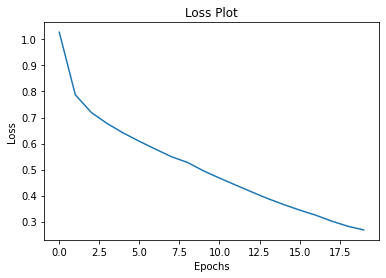

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

<h1>Caption</h1>
평가 기능은 teacher forcing을 사용하지 않는다는 점을 제외하고는 training loop와 비슷하다. <br>
각각의 time step의 디코더로의 입력은 hidden state와 encoder output과 함께 이전의 예측결과 이다. <br>
모델이 end 토큰을 예측할 때 예측이 중지된다.<br>
그리고 매 단계마다 attention wights을 저정한다.<br>

- tf.random.categorical : 범주 형 분포에서 표본을 추출한다.


In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a man takes two pumpkin pies out of the oven <end>
Prediction Caption: a beige stove with a pizza with a pizza in the oven <end>


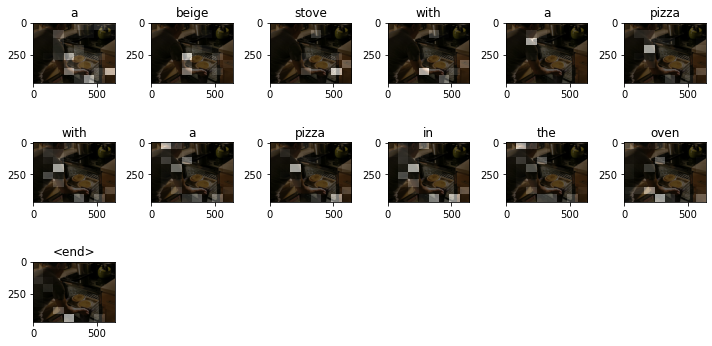

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


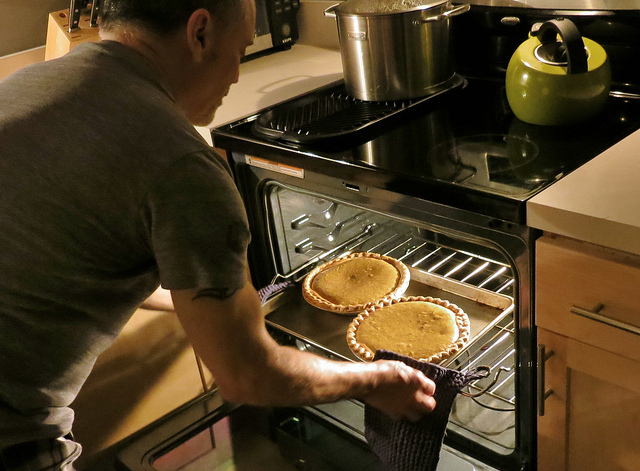

In [ ]:
Image.open(image)

<h1>Test</h1>
상대적으로 적은 양의 데이터로 훈련되었으므로 이미지가 훈련 데이터와 다를 수 있다.

Prediction Caption: a man rides a surfboard in the surf board <end>


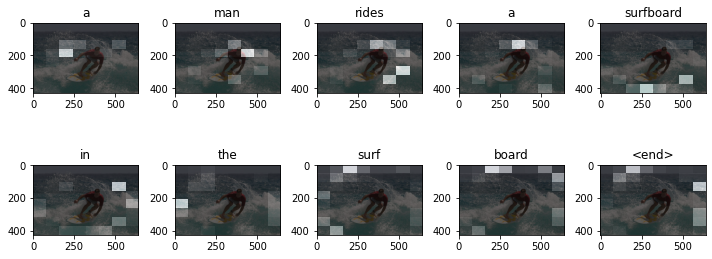

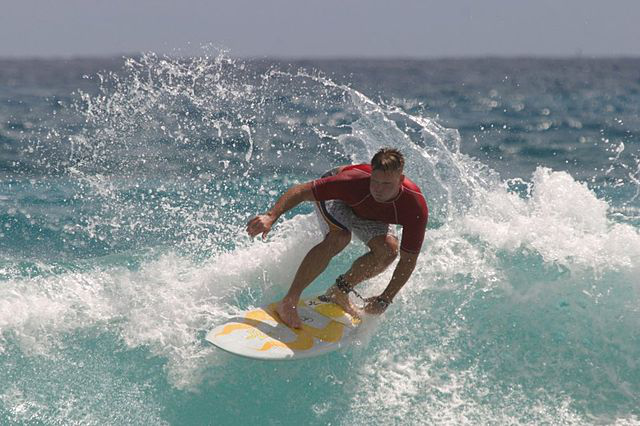

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [ ]:
pwd

'/content'

Prediction Caption: an open standing outside next to a cow <end>


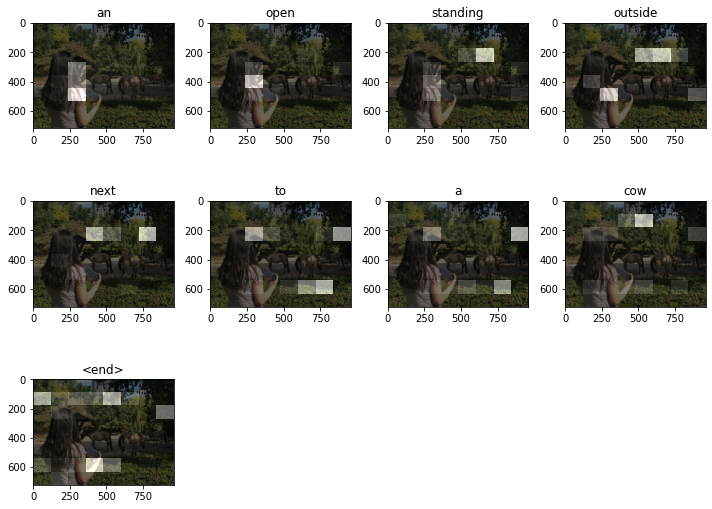

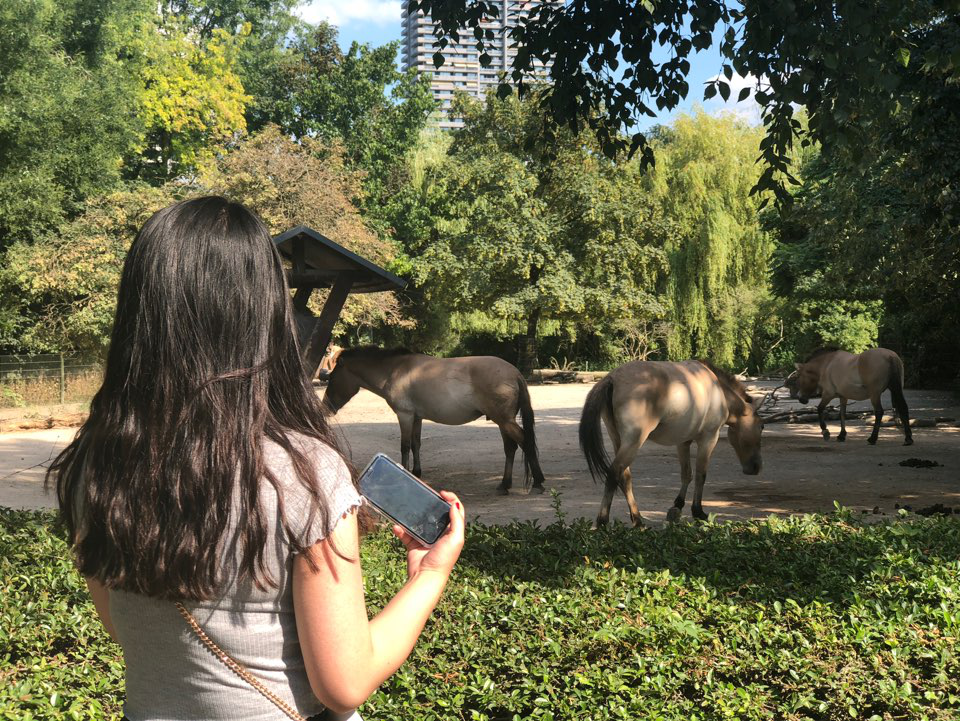

In [ ]:
image_path = './sample_01.jpg'

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Prediction Caption: a person stands on top of a wetsuit <end>


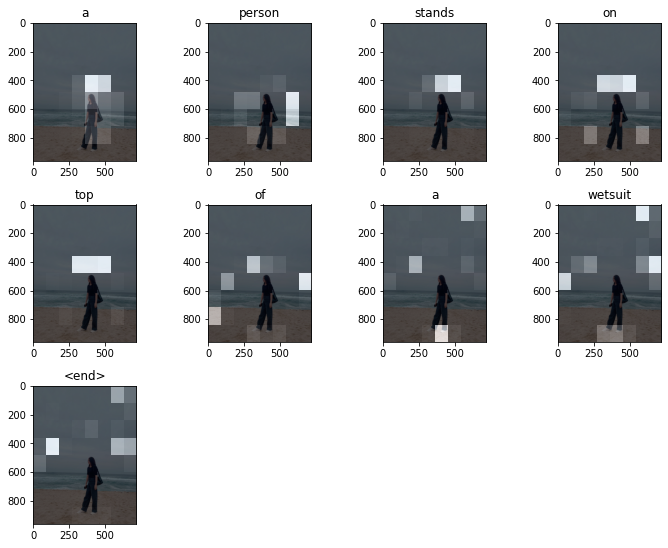

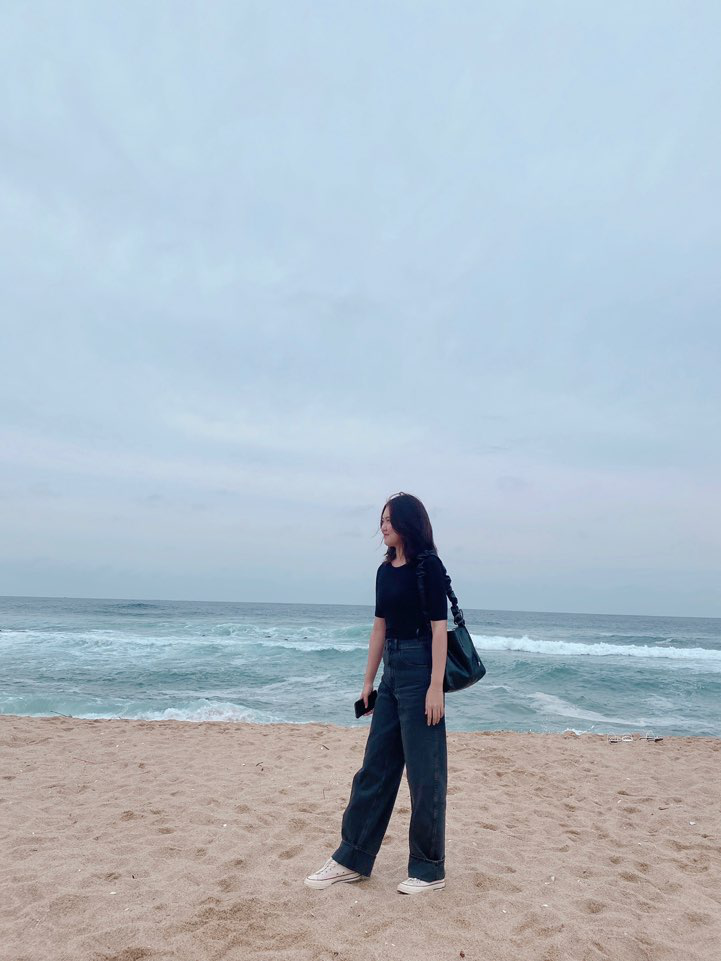

In [ ]:
image_path = './sample_02.jpg'

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Prediction Caption: a woman and tan paint on a bench looking at a small statue <end>


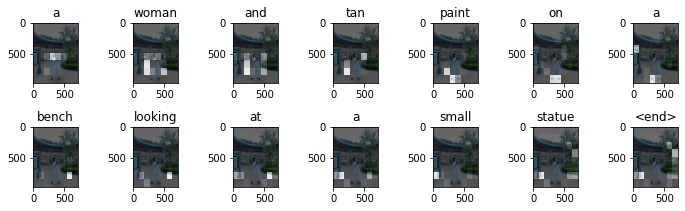

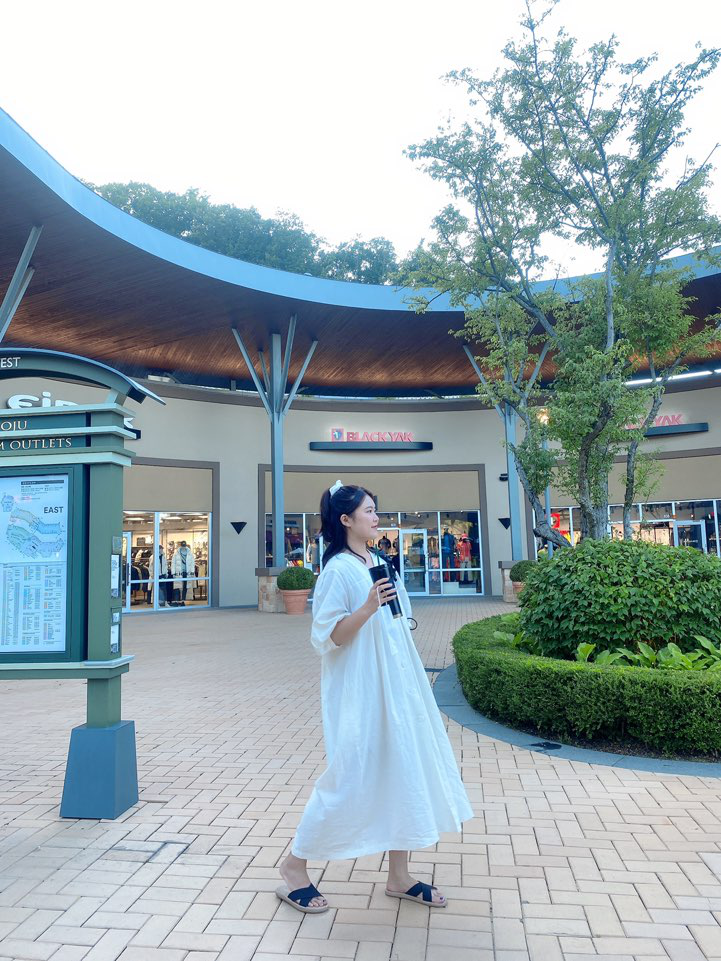

In [ ]:
image_path = './sample_03.jpg'

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Prediction Caption: a woman is standing in front of a microwave <end>


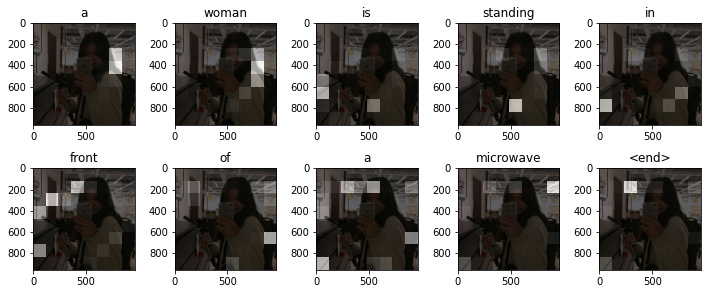

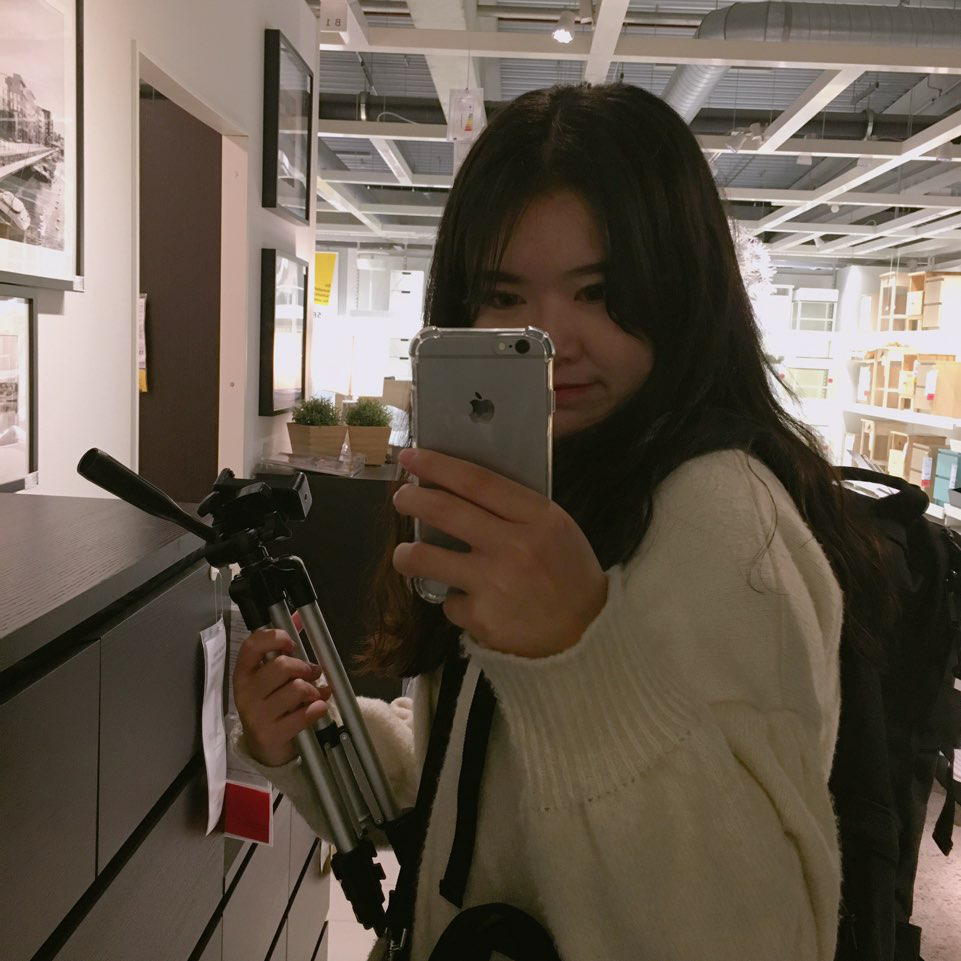

In [ ]:
image_path = './sample_04.jpg'

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Prediction Caption: a laptop computer sitting on a table <end>


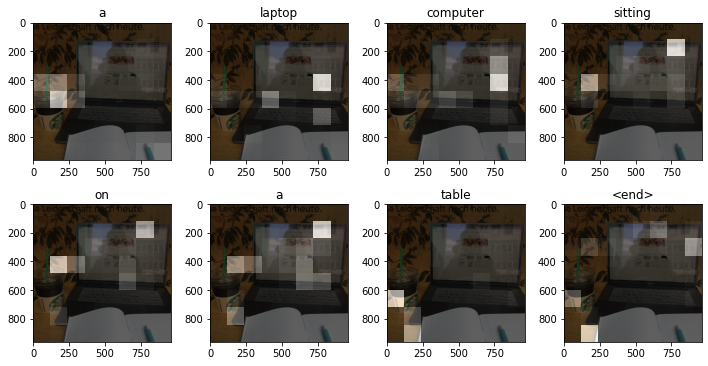

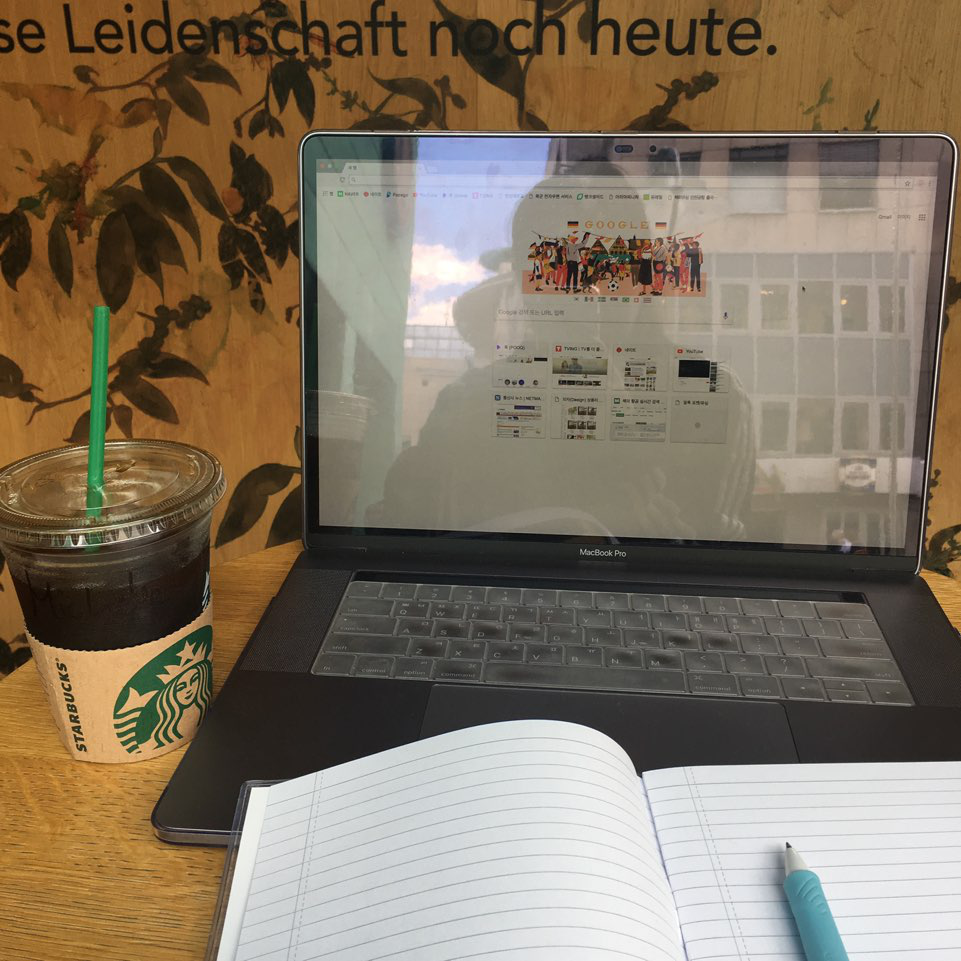

In [ ]:
image_path = './sample_05.jpg'

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Prediction Caption: a double decker buses are stopped on a station <end>


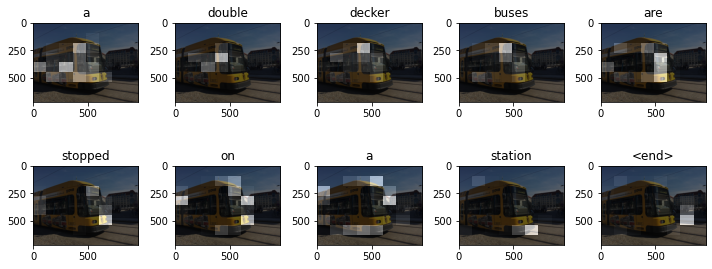

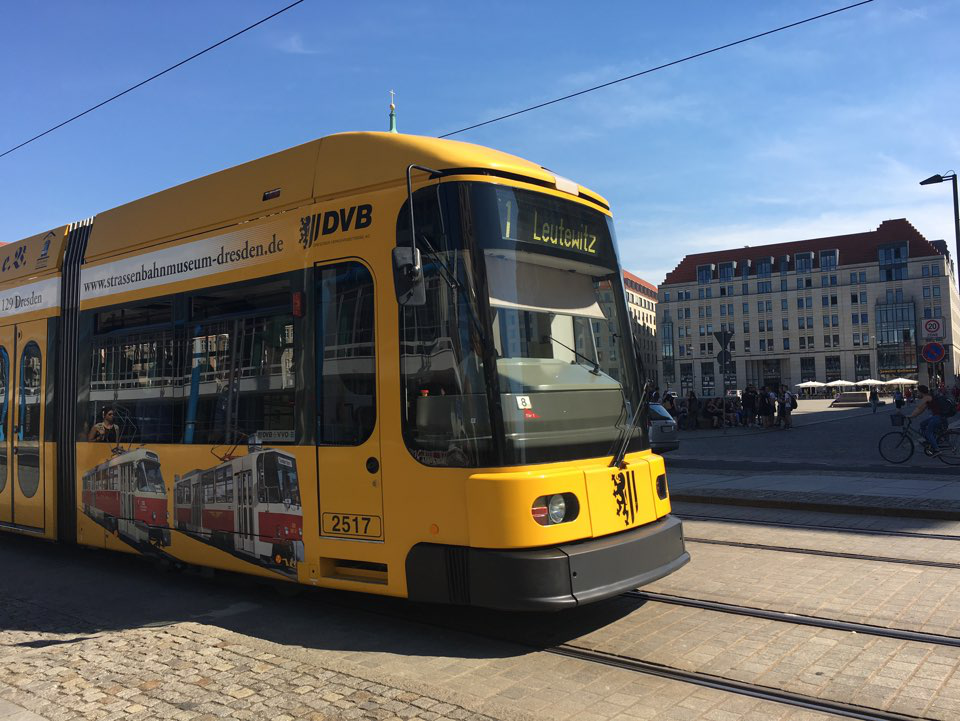

In [ ]:
image_path = './sample_06.jpg'

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)